In [1]:
from collections import defaultdict
from copy import copy
from matplotlib import pyplot as plt
from matplotlib import patches
from multiprocessing import Pool
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
def obtain_xvg(args):
    rep, force = args
    xvg_lines = []
    force_str = str(force // 10 if force % 10 == 0 else force / 10)
    
    skip_counter = 0
    with open("/nfsdata/artem/1sq0/dists/{}_{}.xvg".format(rep, force_str), "r") as f:
        for line in f:
            if skip_counter < 24:
                skip_counter += 1
                continue

            xvg_lines.append([float(s) for s in line.split()])
            
    xvg_arr = np.array(xvg_lines)[:, 1:]
    np.savez_compressed("/data/analytics/catch_bonds/1sq0/dists_npz/{}_{}.npz".format(rep, force_str), xvg_arr)

def get_pair(num, first_chain_len):
    f = num % first_chain_len
    s = num // first_chain_len
    return (f + 1, s + 1)

def get_index(f, s, first_chain_len):
    return (s - 1) * first_chain_len + (f - 1)

In [3]:
FIRST_CHAIN = 198
SECOND_CHAIN = 265
MAX_DIST = 0.3
MIN_OCCUPANCY = 0.1

PAIRS = FIRST_CHAIN * SECOND_CHAIN
FORCES = 21
REPS = 10
FRAMES = 1000

dists_arrs = []

In [ ]:
args = [(rep, force) for rep in range(1, REPS + 1) for force in range(FORCES)]
with Pool(50) as p:
    for i, r in tqdm(enumerate(p.imap(obtain_xvg, args)), total=len(args)):
        pass

In [ ]:
whole_arr = np.zeros((REPS, FORCES, FRAMES, PAIRS), dtype=np.float16)

for rep in tqdm(range(1, REPS + 1)):
    for force in range(FORCES):
        force_str = str(force // 10 if force % 10 == 0 else force / 10)
        npz_file = np.load("/data/analytics/catch_bonds/1sq0/dists_npz/{}_{}.npz".format(rep, force_str))
        whole_arr[rep - 1, force, :, :] = npz_file["arr_0"]

In [ ]:
np.savez_compressed("/data/analytics/catch_bonds/1sq0/dists_npz/whole.npz", whole_arr)

In [4]:
whole_arr = np.load("/data/analytics/catch_bonds/1sq0/dists_npz/whole.npz")["arr_0"]

drop R3_35, R4_35, R8_28, R10_42

In [5]:
candidates = set()

for f in tqdm(range(FORCES)):
    for i in range(whole_arr.shape[3]):
        p_10 = np.percentile(whole_arr[:, f, :, i].flatten(), 10)
        if p_10 < .5:
            candidates.add(i)

In [22]:
z_f_percentiles = [[np.percentile(whole_arr[:, 0, :, c], 5 * p) for p in range(1, 20)] for c in candidates]
diffs_dict = dict()

for c_i, c in enumerate(candidates):
    for f in range(1, whole_arr.shape[1]):
        diffs_dict[(c, f)] = 0
        for p in range(1, 20):
            if f == 4:
                cur_rep = [0, 1, 2, 3, 4, 5, 6, 8, 9]
            elif f == 5:
                cur_rep = [0, 1, 4, 5, 6, 7, 8, 9]
            elif f == 6:
                cur_rep = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            else:
                cur_rep = list(range(10)) 
            cur_p = np.percentile(whole_arr[cur_rep, f, :, c], 5 * p)
            cur_diff = cur_p - z_f_percentiles[c_i][p - 1]
            diffs_dict[(c, f)] += cur_diff

In [23]:
cand_tuples = sorted([(get_pair(k[0], FIRST_CHAIN), k[1], v) for k, v in diffs_dict.items()])
cand_tuples = [(c[0][0] + 1268, c[0][1], c[1] * 7, c[2]) for c in cand_tuples if c[2]]
cand_df = pd.DataFrame(cand_tuples)
cand_df.columns = ["FirstChain", "SecondChain", "Force", "DiffSum"]
[g[1][g[1].Force <= 49] for g in cand_df.groupby(["FirstChain", "SecondChain"]) if any(g[1].DiffSum < -2)]

[     FirstChain  SecondChain  Force    DiffSum
 120        1312           14      7  -1.648608
 121        1312           14     14  -0.543579
 122        1312           14     21  -0.477588
 123        1312           14     28  -0.574829
 124        1312           14     35  -2.114185
 125        1312           14     42   1.069360
 126        1312           14     49  10.164478,
      FirstChain  SecondChain  Force    DiffSum
 940        1332          130      7  -0.133545
 941        1332          130     14  -2.344189
 942        1332          130     21  -2.137109
 943        1332          130     28  -0.415869
 944        1332          130     35  -0.974121
 945        1332          130     42   0.680029
 946        1332          130     49  12.959863,
      FirstChain  SecondChain  Force    DiffSum
 960        1332          230      7   0.350439
 961        1332          230     14  -1.831006
 962        1332          230     21  -2.969446
 963        1332          230     28  

In [ ]:
display_params = [
    (t[0], np.arange(9), np.array([0, 1, 2, 3, 4, 5, 6, 8, 9]), np.arange(9), t[1]) for t in cand_tuples
]

fig = plt.figure(figsize=(18, 3 * len(display_params)))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")

for param_i, param in enumerate(display_params):
    f, s = param[0]
    pair_str = "{}A — {}B".format(f, s)
    r1, r2, r3 = param[1], param[2], param[3]
    force = param[4]
    cur_pair = get_index(f, s, FIRST_CHAIN)
    
    XMAX = 5
    YMAX = 4

    ylims = []
    axes = []
    
    ax = fig.add_subplot(len(display_params) // 2, 2, 1 + param_i * 1)
    cur_line = sns.kdeplot(whole_arr[r1, 0, :, cur_pair].flatten(), bw=.05, label="0 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_xlabel("Distance", fontdict={"size": 14})
    ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 14})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r2, force, :, cur_pair].flatten(), bw=.05, label="{} pN".format(force * 7), linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_title("{}".format(pair_str), fontdict={"size": 18})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r3, 9, :, cur_pair].flatten(), bw=.05, label="63 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    axes.append(ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=20)
    
    for ax in axes:
        ax.set_xlim(0, 5)
        ax.set_ylim(0, np.max([l[1] for l in ylims]))
        
        [t.set_fontsize(16) for t in ax.get_xticklabels()]
        ax.set_xlabel("Distance, Å", fontdict={"size": 16})
        [t.set_fontsize(16) for t in ax.get_yticklabels()]
        ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 20})
        
plt.tight_layout()

In [ ]:
zero_force_flatten = whole_arr[:, 0, :, :].reshape(-1, whole_arr.shape[3])
zero_force_medians = np.median(zero_force_flatten, axis=0)
zero_force_contacts = zero_force_medians < 1

force_pairs_dict = dict()
results = []

for force in tqdm(range(1, FORCES), total=FORCES - 1):
    m_force_flatten = whole_arr[:, force, :, :].reshape(-1, whole_arr.shape[3])
    m_force_medians = np.median(m_force_flatten, axis=0)
    for i, (f, z) in enumerate(zip(m_force_medians.tolist(), zero_force_medians.tolist())):
        if f < .9 * z and f < 1:
            results.append((f, z, force, get_pair(i, FIRST_CHAIN)))

In [ ]:
median_tuples = [t for t in sorted(results, key=lambda t: t[2] / t[1]) if t[0] < .6]

In [ ]:
display_params = [
    (t[3], np.arange(9), np.array([0, 1, 2, 3, 4, 5, 6, 8, 9]), np.arange(9), t[2]) for t in median_tuples
]

fig = plt.figure(figsize=(18, 3 * len(display_params)))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")

for param_i, param in enumerate(display_params):
    f, s = param[0]
    pair_str = "{}A — {}B".format(f, s)
    r1, r2, r3 = param[1], param[2], param[3]
    force = param[4]
    cur_pair = get_index(f, s, FIRST_CHAIN)
    
    XMAX = 5
    YMAX = 4

    ylims = []
    axes = []
    
    ax = fig.add_subplot(len(display_params) // 2, 2, 1 + param_i * 1)
    cur_line = sns.kdeplot(whole_arr[r1, 0, :, cur_pair].flatten(), bw=.05, label="0 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_xlabel("Distance", fontdict={"size": 14})
    ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 14})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r2, force, :, cur_pair].flatten(), bw=.05, label="{} pN".format(force * 7), linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_title("{}".format(pair_str), fontdict={"size": 18})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r3, 9, :, cur_pair].flatten(), bw=.05, label="63 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    axes.append(ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=20)
    
    for ax in axes:
        ax.set_xlim(0, 5)
        ax.set_ylim(0, np.max([l[1] for l in ylims]))
        
        [t.set_fontsize(16) for t in ax.get_xticklabels()]
        ax.set_xlabel("Distance, Å", fontdict={"size": 16})
        [t.set_fontsize(16) for t in ax.get_yticklabels()]
        ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 20})
        
plt.tight_layout()

In [26]:
!cat /data/analytics/catch_bonds/1sq0/dists_max_chains/10_0.1.xvg | tail -n +25

     -1.000    7.383
      0.000    7.379
      1.000    7.440
      2.000    7.486
      3.000    7.404
      4.000    7.396
      5.000    7.449
      6.000    7.530
      7.000    7.508
      8.000    7.417
      9.000    7.395
     10.000    7.356
     11.000    7.531
     12.000    7.531
     13.000    7.647
     14.000    7.505
     15.000    7.554
     16.000    7.558
     17.000    7.499
     18.000    7.453
     19.000    7.382
     20.000    7.291
     21.000    7.361
     22.000    7.454
     23.000    7.487
     24.000    7.447
     25.000    7.487
     26.000    7.583
     27.000    7.517
     28.000    7.654
     29.000    7.476
     30.000    7.405
     31.000    7.506
     32.000    7.370
     33.000    7.362
     34.000    7.438
     35.000    7.551
     36.000    7.509
     37.000    7.759
     38.000    7.667
     39.000    7.486
     40.000    7.426
     41.000    7.569
     42.000    7.375
     43.000    7.440
     44.000    7.447
     45.000    7.613
     46.000  

In [68]:
PREFIX = "/data/analytics/catch_bonds/1sq0/dists_max_chains"
mean_dist_dict = defaultdict(list)
std_dist_dict = defaultdict(list)

for rep in range(1, 11):
    for force in np.arange(0, 2.1, .1):
        force_str = str(int(force)) if force == int(force) else str(force)
        dists_df = pd.read_csv("{}/{}_{}.xvg".format(PREFIX, rep, force_str), skiprows=24, header=None, sep="\s+")
        dists_df.columns = ["frame", "max_dist"]
        
        mean_dist_dict[force].append(dists_df.max_dist.mean())
        std_dist_dict[force].append(dists_df.max_dist.std())

Text(0,0.5,'Mean maximum distance')

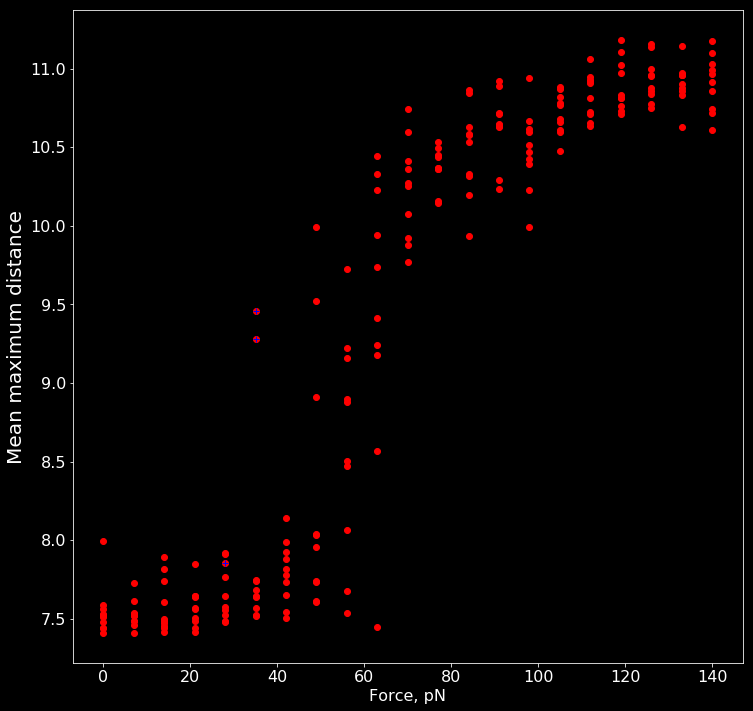

In [70]:
fig = plt.figure(figsize=(12, 12))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")
ax = fig.add_subplot(1, 1, 1)

for k, v in mean_dist_dict.items():
    ax.plot([k * 70] * len(v), v, "ro")
    if k == .4:
        ax.plot([k * 70], [v[7]], "b+")
    if k == .5:
        ax.plot([k * 70] * 2, [v[2], v[3]], "b+")
    if k == .7:
        ax.plot([k * 70], [v[9]], "b+")
    
[t.set_fontsize(16) for t in ax.get_xticklabels()]
ax.set_xlabel("Force, pN", fontdict={"size": 16})
[t.set_fontsize(16) for t in ax.get_yticklabels()]
ax.set_ylabel("Mean maximum distance", fontdict={"size": 20})

In [48]:
PREFIX = "/data/analytics/catch_bonds/1sq0/dists_max_chains"
lifetime_dict = defaultdict(list)

for rep in range(1, 11):
    for force in np.arange(0, 2.1, .1):
        force_str = str(int(force)) if force == int(force) else str(force)
        dists_df = pd.read_csv("{}/{}_{}.xvg".format(PREFIX, rep, force_str), skiprows=24, header=None, sep="\s+")
        dists_df.columns = ["frame", "max_dist"]
        
        try:
            lifetime_dict[force].append((np.where(dists_df.max_dist > 9))[0][0])
        except IndexError:
            lifetime_dict[force].append(1000)

Text(0,0.5,'Mean lifetime, frames')

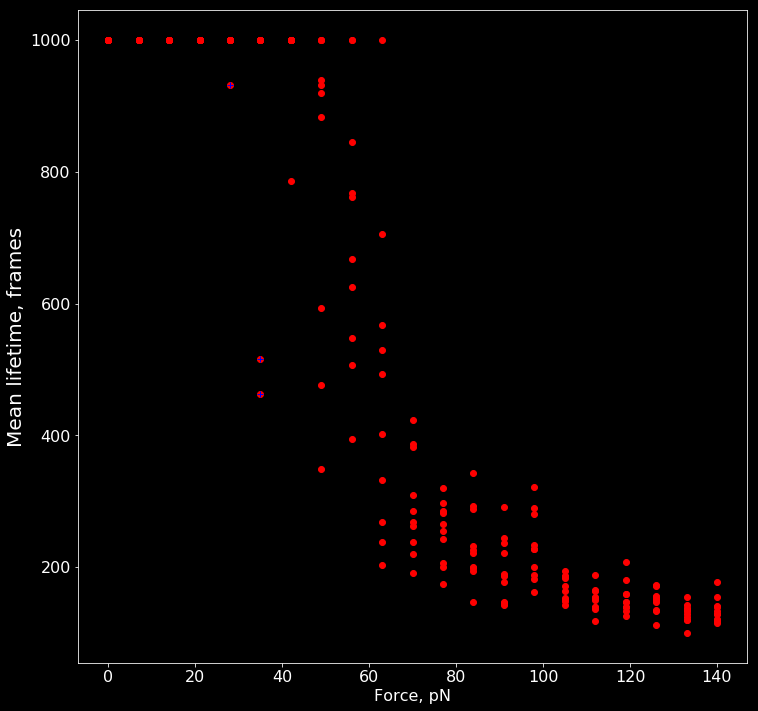

In [52]:
fig = plt.figure(figsize=(12, 12))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")
ax = fig.add_subplot(1, 1, 1)

for k, v in lifetime_dict.items():
    ax.plot([k * 70] * len(v), v, "ro")
    if k == .4:
        ax.plot([k * 70], [v[7]], "b+")
    if k == .5:
        ax.plot([k * 70] * 2, [v[2], v[3]], "b+")
    if k == .7:
        ax.plot([k * 70], [v[9]], "b+")
    
[t.set_fontsize(16) for t in ax.get_xticklabels()]
ax.set_xlabel("Force, pN", fontdict={"size": 16})
[t.set_fontsize(16) for t in ax.get_yticklabels()]
ax.set_ylabel("Mean lifetime, frames", fontdict={"size": 20})